# **Zillow Clustering Project**

## Project Goals
- Create documented files to clean and prepare Zillow dataset for processing by clustering algorithm for further modeling via a regression ML algorithm.
- Attempt to use clustering to identify driving features of log error and to potentially create new feature combinations or simply to use the cluster as a driving feature.
- Evaluate the clusters and try to extrapolate usefull info from them.
- Pass updated dataframe with new features/chosen features/cluster features to a regression model and evaluate it.
- Present on my final Jupyter Notebook, giving a high-level overview of the process used to create the clusters and how the information garnered from them is useful to my regression model.

## Executive Summary:
#### Key Findings:
- None of the variables are clearly indicative of logerror
- Model still outpreformed baseline by small margin
- Features most linked to logerror and used in model: `'census_tb', 'county_Ventura', 'bedrooms',
  'month_sold_1', 'home_area', 'latitude', 'longitude', 'tax_paid'`
- Model was insignificant overall

#### Reccomendation:
- I reccomend to stick with existing zestimate algorithm and not rely on the features presented here to predict the logerror of the zestimate.

## Initial Hypotheses:
***
>   - $H_{i}$: The key drivers of log error will be linked to tax value and area
***

In [1]:
# Imports from my .py scripts and modules necessary 
# for modeling and exploring data 
import wrangle as wr
import explore as ex
import model as md

import random
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
import sklearn.preprocessing
import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import itertools
import datetime

%matplotlib inline
np.set_printoptions(suppress=True)
import warnings
warnings.filterwarnings("ignore")

## Wrangle
- Acquire zillow data from MySQL database
- Summarize raw data to find missing/null values
- Impute, clean, and prepare data for exploration by dropping null columns and rows
- Get basic distribution info for each column
- Split data into train, validate, test sets for use in exploration

### Acquire

In [2]:
# Acquire Zillow data from MySQL database

zillow_raw = wr.acquire_zillow()

In [3]:
zillow_raw.shape

(77381, 67)

In [4]:
# Sample of raw data
zillow_raw.head().T

,0,1,2,3,4
parcelid,14297519,17052889,14186244,12177905,10887214
airconditioningtypeid,NaN,NaN,NaN,NaN,1.0
architecturalstyletypeid,NaN,NaN,NaN,NaN,NaN
basementsqft,NaN,NaN,NaN,NaN,NaN
bathroomcnt,3.5,1.0,2.0,3.0,3.0
...,...,...,...,...,...
buildingclassdesc,NaN,NaN,NaN,NaN,NaN
heatingorsystemdesc,NaN,NaN,NaN,Central,Central
propertylandusedesc,Single Family Residential,Single Family Residential,Single Family Residential,Single Family Residential,Condominium
storydesc,NaN,NaN,NaN,NaN,NaN


In [5]:
# Overview of raw data
wr.summarize(zillow_raw)



Dataframe info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77381 entries, 0 to 77380
Data columns (total 67 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77381 non-null  int64  
 1   airconditioningtypeid         24953 non-null  float64
 2   architecturalstyletypeid      206 non-null    float64
 3   basementsqft                  50 non-null     float64
 4   bathroomcnt                   77381 non-null  float64
 5   bedroomcnt                    77381 non-null  float64
 6   buildingclasstypeid           15 non-null     float64
 7   buildingqualitytypeid         49672 non-null  float64
 8   calculatedbathnbr             76772 non-null  float64
 9   decktypeid                    614 non-null    float64
 10  finishedfloor1squarefeet      6023 non-null   float64
 11  calculatedfinishedsquarefeet  77185 non-null  float64
 12  finishedsquarefeet12          73749 non-n

(-6734.775000000001, 697313.4]    68856
(697313.4, 1394390.8]               227
(1394390.8, 2091468.2]               40
(2091468.2, 2788545.6]                2
(2788545.6, 3485623.0]                1
(3485623.0, 4182700.4]                9
(4182700.4, 4879777.8]                0
(4879777.8, 5576855.2]                0
(5576855.2, 6273932.6]                0
(6273932.6, 6971010.0]                7
Name: lotsizesquarefeet, dtype: int64
(0.9989, 0.9992]        0
(0.9992, 0.9994]        0
(0.9994, 0.9996]        0
(0.9996, 0.9998]        0
(0.9998, 1.0]       16137
(1.0, 1.0002]           0
(1.0002, 1.0004]        0
(1.0004, 1.0006]        0
(1.0006, 1.0008]        0
(1.0008, 1.001]         0
Name: poolcnt, dtype: int64
(22.523, 171.6]       7
(171.6, 319.2]       47
(319.2, 466.8]      322
(466.8, 614.4]      306
(614.4, 762.0]      123
(762.0, 909.6]       48
(909.6, 1057.2]       7
(1057.2, 1204.8]      5
(1204.8, 1352.4]      0
(1352.4, 1500.0]      2
Name: poolsizesum, dtype: int64
(0

(2.903, 12.6]     351
(12.6, 22.2]     2534
(22.2, 31.8]        0
(31.8, 41.4]        0
(41.4, 51.0]        0
(51.0, 60.6]        0
(60.6, 70.2]        0
(70.2, 79.8]        0
(79.8, 89.4]        0
(89.4, 99.0]        1
Name: taxdelinquencyyear, dtype: int64
(59948352007016.984, 102636920499301.5]    77136
(102636920499301.5, 144902829897603.0]         0
(144902829897603.0, 187168739295904.5]         0
(187168739295904.5, 229434648694206.03]        0
(229434648694206.03, 271700558092507.5]        0
(271700558092507.5, 313966467490809.0]         0
(313966467490809.0, 356232376889110.5]         0
(356232376889110.5, 398498286287411.94]        0
(398498286287411.94, 440764195685713.5]        0
(440764195685713.5, 483030105084015.0]         1
Name: censustractandblock, dtype: int64
(-4.666, -3.664]        3
(-3.664, -2.672]        1
(-2.672, -1.68]        36
(-1.68, -0.688]       142
(-0.688, 0.304]     75340
(0.304, 1.296]       1684
(1.296, 2.287]        102
(2.287, 3.279]         71
(3.

### Prepare

In [6]:
# Prepping raw zillow data, imputing in year_built,
# dropping nulls, outliers and columns with too many null vals
# such as storytypeid with only 50 non-null vals

zillow_prep = wr.wrangle_zillow()

In [7]:
zillow_prep.shape

(37435, 23)

In [8]:
# Dropped column/row count
print(f'Dropped {zillow_raw.shape[1] - zillow_prep.shape[1]} \
columns. \nDropped {zillow_raw.shape[0] - zillow_prep.shape[0]} rows.')

Dropped 44 columns. 
Dropped 39946 rows.


In [9]:
zillow_prep.head().T

,0,2,3,6,8
bathrooms,3.5,2.0,3.0,3.0,3.0
bedrooms,4.0,3.0,4.0,4.0,4.0
quality_id,6,6,8,9,9
home_area,3100.0,1243.0,2376.0,2962.0,3039.0
latitude,33634931.0,33886168.0,34245180.0,34145202.0,33960230.0
longitude,-117869207.0,-117823170.0,-118240722.0,-118179824.0,-118006914.0
lot_area,4506.0,8432.0,13038.0,63000.0,20028.0
census_tb,60590630.072012,60590218.022012,60373001.001006,60374608.001014,60375002.024006
city_id,53571,21412,396551,47019,14634
county_id,1286,1286,3101,3101,3101


In [10]:
wr.summarize(zillow_prep)



Dataframe info: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 37435 entries, 0 to 77379
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bathrooms       37435 non-null  float64
 1   bedrooms        37435 non-null  float64
 2   quality_id      37435 non-null  int64  
 3   home_area       37435 non-null  float64
 4   latitude        37435 non-null  float64
 5   longitude       37435 non-null  float64
 6   lot_area        37435 non-null  float64
 7   census_tb       37435 non-null  float64
 8   city_id         37435 non-null  int64  
 9   county_id       37435 non-null  int64  
 10  zip_code        37435 non-null  int64  
 11  roomcnt         37435 non-null  int64  
 12  structure_tax   37435 non-null  float64
 13  tax_value       37435 non-null  float64
 14  land_tax_value  37435 non-null  float64
 15  tax_paid        37435 non-null  float64
 16  logerror        37435 non-null  float64
 17  heating_type

                  count          mean            std           min  \
bathrooms       37435.0  2.349245e+00       0.485456  1.500000e+00   
bedrooms        37435.0  3.389849e+00       0.759203  1.000000e+00   
quality_id      37435.0  6.385148e+00       1.073723  3.000000e+00   
home_area       37435.0  1.882202e+03     622.654032  5.400000e+02   
latitude        37435.0  3.402565e+07  290082.671743  3.334062e+07   
longitude       37435.0 -1.181849e+08  375492.569582 -1.194753e+08   
lot_area        37435.0  1.079104e+04   98492.826599  2.360000e+02   
census_tb       37435.0  6.051470e+07  219989.586365  6.037101e+07   
city_id         37435.0  3.215428e+04   44288.598048  3.491000e+03   
county_id       37435.0  2.432372e+03     828.751970  1.286000e+03   
zip_code        37435.0  9.669773e+04    4449.613576  9.598200e+04   
roomcnt         37435.0  2.303753e+00       3.325581  0.000000e+00   
structure_tax   37435.0  1.707079e+05  125489.135937  3.020000e+02   
tax_value       3743

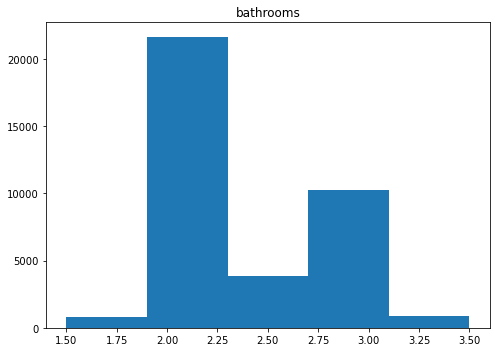

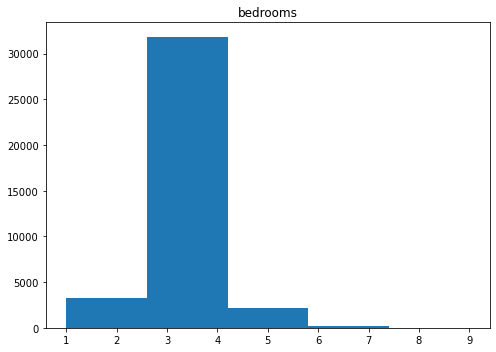

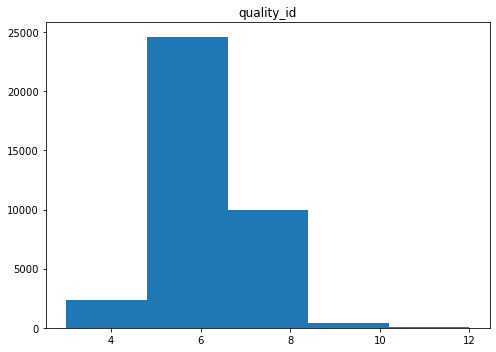

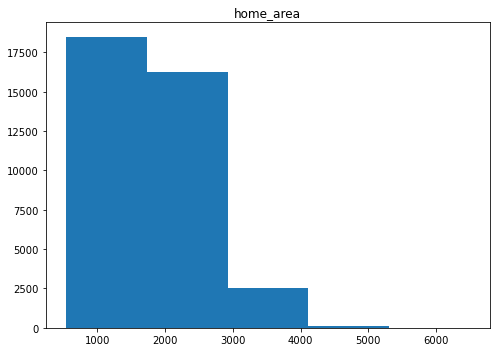

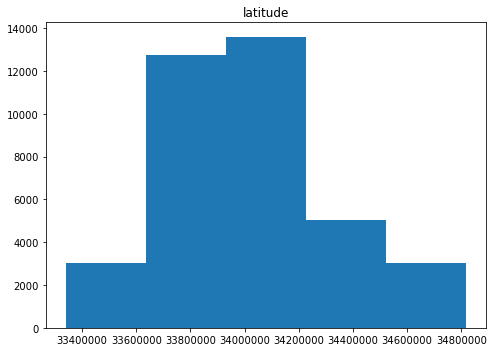

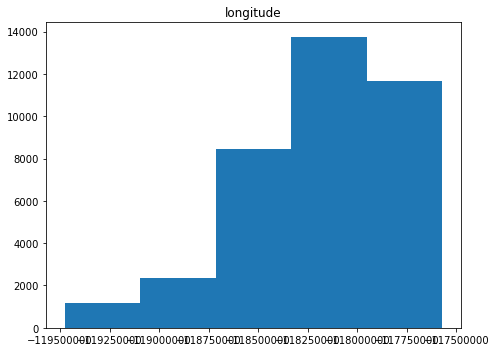

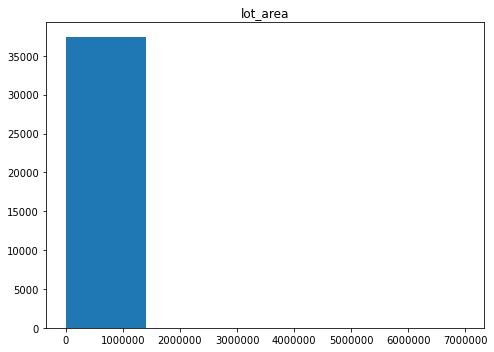

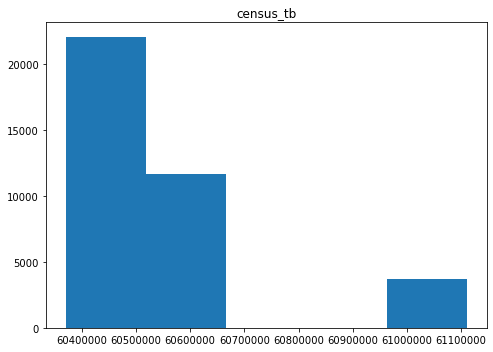

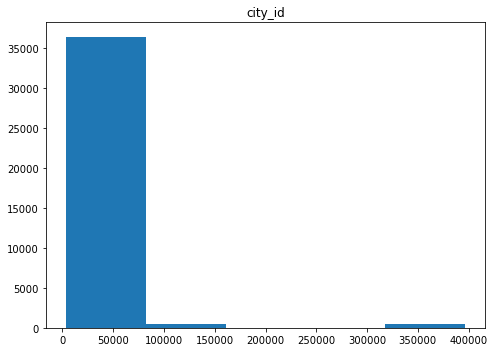

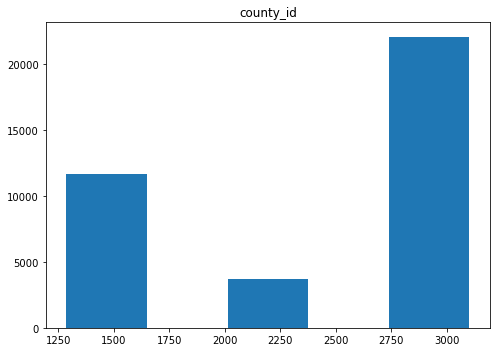

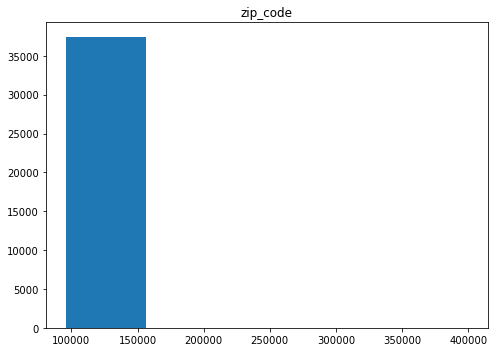

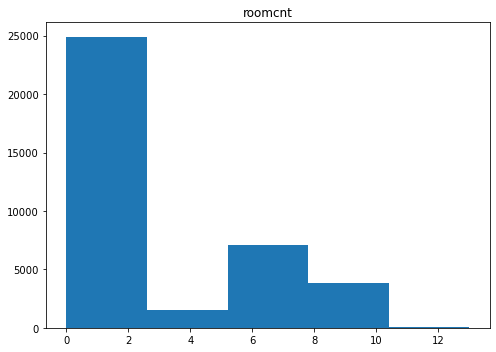

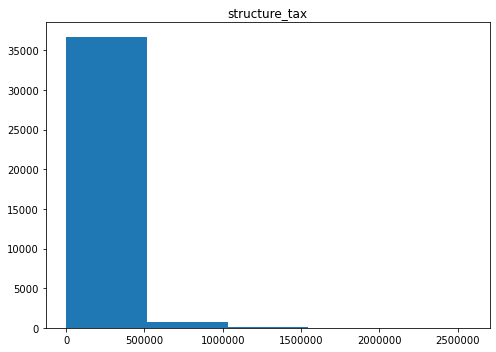

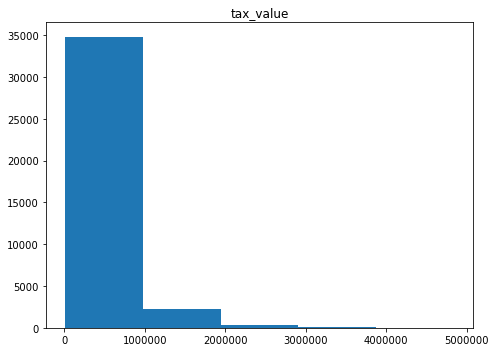

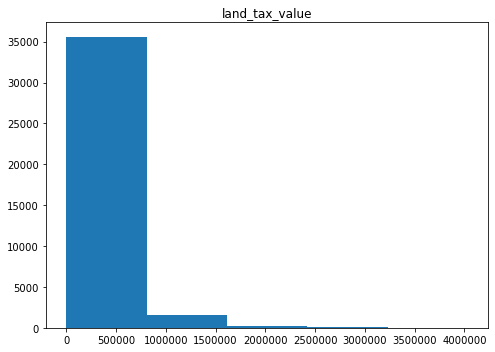

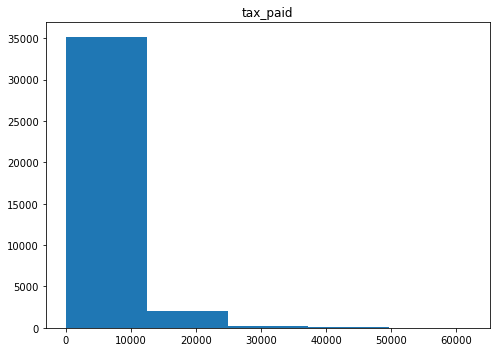

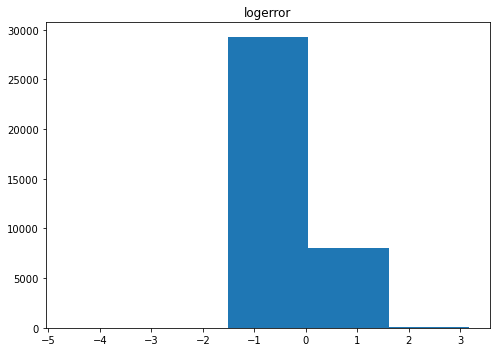

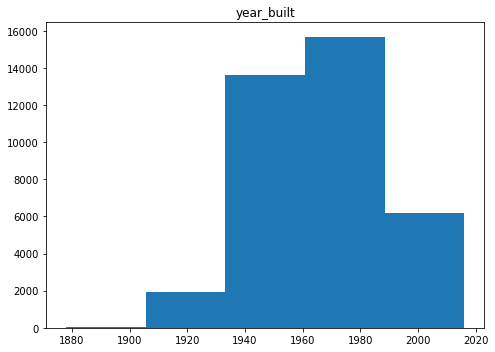

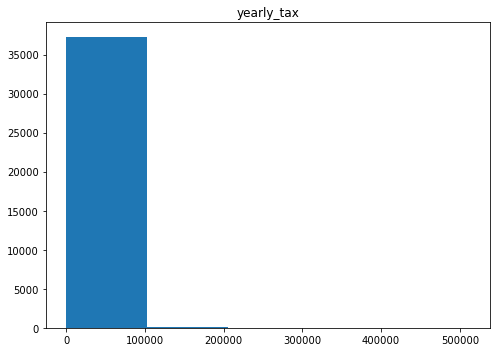

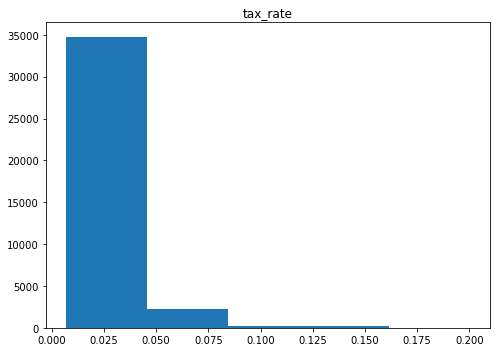

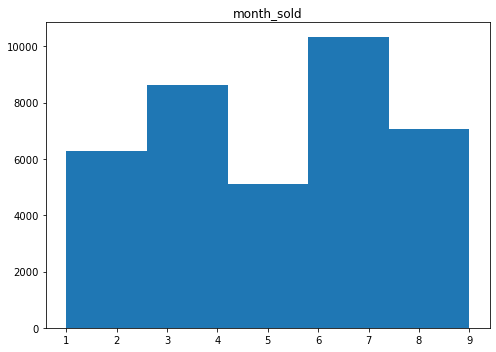

In [11]:
# Visualizing distributions
ex.hist_combos(zillow_prep)

#### Distribution takeaways:
- Only quality id is normally distributed
    - non-parametric tests due to lack of normal distributions

In [12]:
# Split without target variable removed for exploration
explore_train, explore_validate, explore_test = wr.train_validate_test_split(zillow_prep) 

In [13]:
explore_train.head().T

,72596,68566,23838,44498,40785
bathrooms,1.5,2.0,2.0,3.0,2.0
bedrooms,3.0,3.0,3.0,4.0,3.0
quality_id,6,4,6,6,6
home_area,1457.0,1113.0,1358.0,3313.0,1560.0
latitude,34196927.0,33868724.0,34287576.0,33458711.0,33718867.0
longitude,-118860052.0,-118198923.0,-118451873.0,-117616553.0,-117755180.0
lot_area,10404.0,4780.0,7733.0,7866.0,5000.0
census_tb,61110068.002008,60375704.023003,60371066.491004,60590421.123008,60590524.212002
city_id,34278,46298,47547,13693,52650
county_id,2061,3101,3101,1286,1286


# Explore
### Preliminary exploration:
- Encode columns where col.dtype == object
- Separate feats
- Create scaled versions of explore train, validate, and test datasets
- Cluster on variables indicated in RFE and manual exploration
- Preform stat tests to further examine relations between variables
- Visualize questions I develop during exploration

In [14]:
# Creating scaled copies of each dataframe
scaler, scaled_etrain, scaled_evaluate, scaled_etest =  ex.scaling(explore_train, explore_validate, explore_test, scaler_type = sklearn.preprocessing.MinMaxScaler())

scaled_etrain.head().T

,72596,68566,23838,44498,40785
bathrooms,0.0,0.25,0.25,0.75,0.25
bedrooms,0.25,0.25,0.25,0.375,0.25
quality_id,0.333333,0.111111,0.333333,0.333333,0.333333
home_area,0.167805,0.098674,0.14791,0.540796,0.188505
latitude,0.579245,0.357174,0.640581,0.079747,0.255776
longitude,0.323298,0.670726,0.537799,0.976765,0.903915
lot_area,0.001459,0.000652,0.001075,0.001095,0.000683
census_tb,0.999969,0.00635,0.000075,0.296869,0.297009
city_id,0.078325,0.108906,0.112083,0.025955,0.125066
county_id,0.426997,1.0,1.0,0.0,0.0


In [15]:
# Separating feats into categorical and quantitative feats
feats, cats, quants = ex.separate_feats(explore_train)

In [16]:
# Encoding cols for processing and exploration
cols =['heating_type', 'county', 'month_sold']

enc_train, enc_validate, enc_test = ex.encode_cols(scaled_etrain, scaled_evaluate, scaled_etest, cols)
enc_train.head().T

,72596,68566,23838,44498,40785
bathrooms,0.000000,0.250000,0.250000,0.750000,0.250000
bedrooms,0.250000,0.250000,0.250000,0.375000,0.250000
quality_id,0.333333,0.111111,0.333333,0.333333,0.333333
home_area,0.167805,0.098674,0.147910,0.540796,0.188505
latitude,0.579245,0.357174,0.640581,0.079747,0.255776
longitude,0.323298,0.670726,0.537799,0.976765,0.903915
lot_area,0.001459,0.000652,0.001075,0.001095,0.000683
census_tb,0.999969,0.006350,0.000075,0.296869,0.297009
city_id,0.078325,0.108906,0.112083,0.025955,0.125066
county_id,0.426997,1.000000,1.000000,0.000000,0.000000


## Hypothesis Testing
- Test for co-linearity between categorical variables
- Run a Pearsons r test in an attempt to find clear drivers of logerror

In [17]:
# run a chi2_contingency test on target cat_var for colinearity with bedrooms
ex.co_linearity(scaled_etrain, 'bedrooms', cats)

,feature,p_values,chi2
0,bathrooms,0.000000e+00,3694.504726
1,quality_id,0.000000e+00,167704.000000
2,heating_type,0.000000e+00,6692.469099
3,county,6.456051e-100,617.418304
4,county_id,2.583933e-60,473.087040
5,roomcnt,8.359994e-59,321.619331
6,month_sold,8.359994e-59,321.619331


In [18]:
# run a chi2_contingency test on target cat_var for colinearity with bathrooms
ex.co_linearity(scaled_etrain, 'bathrooms', cats)

,feature,p_values,chi2
0,bedrooms,0.0,83852.000000
1,quality_id,0.0,3694.504726
2,county_id,0.0,5193.797018
3,roomcnt,0.0,5234.670609
4,heating_type,0.0,6639.230524
5,county,0.0,6119.683923
6,month_sold,0.0,5234.670609


In [19]:
# run a chi2_contingency test on target cat_var for colinearity with other feats
ex.co_linearity(scaled_etrain, 'county', cats)

,feature,p_values,chi2
0,bathrooms,0.000000e+00,5234.670609
1,quality_id,0.000000e+00,7846.317010
2,county_id,0.000000e+00,41926.000000
3,roomcnt,0.000000e+00,15713.091401
4,heating_type,0.000000e+00,20778.409357
5,month_sold,0.000000e+00,41926.000000
6,bedrooms,8.359994e-59,321.619331


In [20]:
# run a chi2_contingency test on target cat_var for colinearity with other feats
ex.co_linearity(scaled_etrain, 'month_sold', cats)

,feature,p_values,chi2
0,county,0.000137,45.027712
1,county_id,0.000137,45.027712
2,bathrooms,0.000593,64.383796
3,heating_type,0.000650,85.823002
4,quality_id,0.001323,113.469326
5,roomcnt,0.187747,99.568435
6,bedrooms,0.688968,57.952346


#### Co-linearity takeaways:
- Almost all of the categorical variables exhibit at least mild co-linearity

In [21]:
# run a pearsonsr test on logerror and quant vars
ex.pearsons(scaled_etrain, 'logerror', quants)

,feature,p_values,corr
0,home_area,0.000450,0.024231
1,latitude,0.003117,-0.020415
2,longitude,0.004205,0.019769
3,tax_paid,0.043822,-0.013923
4,land_tax_value,0.044893,-0.013853
5,yearly_tax,0.059436,0.013019
6,tax_value,0.067575,-0.012625
7,year_built,0.300490,0.007151
8,structure_tax,0.450989,-0.005206
9,census_tb,0.464101,0.005057


#### Pearsons r Takeaways:
- logerror has some level of correlation with home_area, latitude, longitude, tax_paid and land_tax_value even if small

### Visualizations:

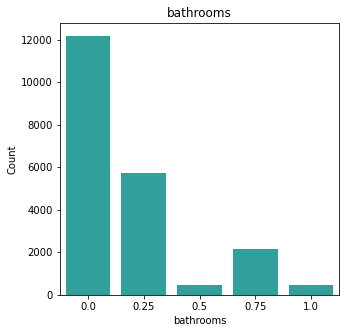

   bathrooms  Count  Percent
0       0.00  12173    58.07
1       0.25   5708    27.23
2       0.75   2153    10.27
3       0.50    481     2.29
4       1.00    448     2.14
_________________________________________________________________


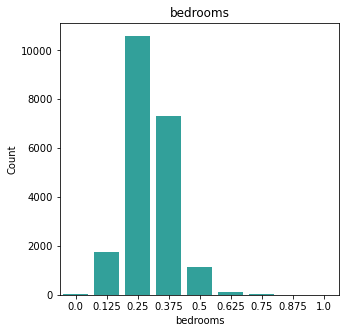

   bedrooms  Count  Percent
0     0.250  10588    50.51
1     0.375   7293    34.79
2     0.125   1769     8.44
3     0.500   1153     5.50
4     0.625    102     0.49
5     0.000     35     0.17
6     0.750     21     0.10
7     1.000      1     0.00
8     0.875      1     0.00
_________________________________________________________________


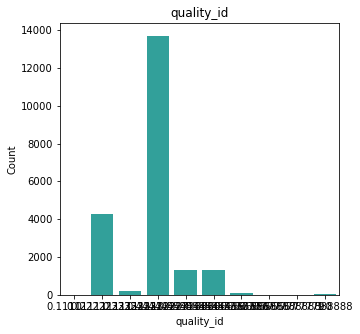

   quality_id  Count  Percent
0    0.333333  13681    65.26
1    0.111111   4273    20.38
2    0.555556   1335     6.37
3    0.444444   1312     6.26
4    0.222222    220     1.05
5    0.666667     80     0.38
6    1.000000     47     0.22
7    0.888889      9     0.04
8    0.777778      3     0.01
9    0.000000      3     0.01
_________________________________________________________________


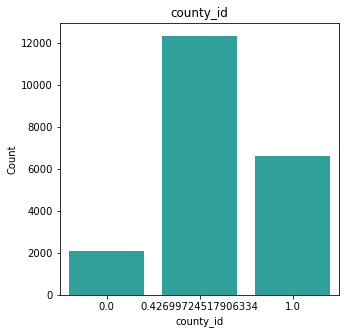

   county_id  Count  Percent
0   0.426997  12308    58.71
1   1.000000   6586    31.42
2   0.000000   2069     9.87
_________________________________________________________________


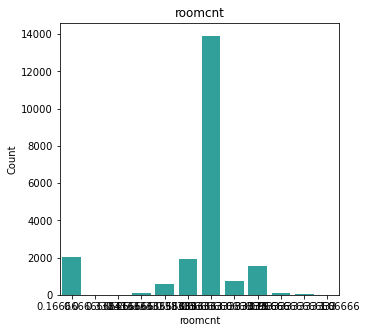

     roomcnt  Count  Percent
0   0.583333  13902    66.32
1   0.000000   2054     9.80
2   0.500000   1908     9.10
3   0.750000   1535     7.32
4   0.666667    767     3.66
5   0.416667    556     2.65
6   0.833333    113     0.54
7   0.333333     98     0.47
8   0.916667     17     0.08
9   0.250000      6     0.03
10  0.166667      5     0.02
11  1.000000      2     0.01
_________________________________________________________________


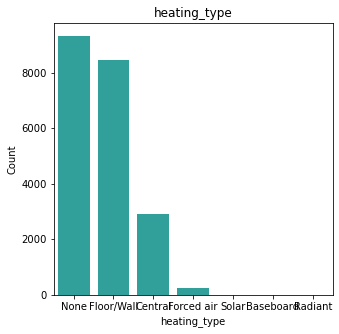

  heating_type  Count  Percent
0         None   9319    44.45
1   Floor/Wall   8459    40.35
2      Central   2897    13.82
3   Forced air    264     1.26
4        Solar     14     0.07
5    Baseboard      6     0.03
6      Radiant      4     0.02
_________________________________________________________________


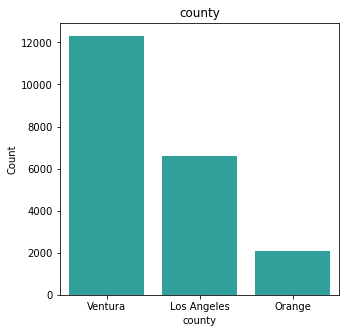

        county  Count  Percent
0      Ventura  12308    58.71
1  Los Angeles   6586    31.42
2       Orange   2069     9.87
_________________________________________________________________


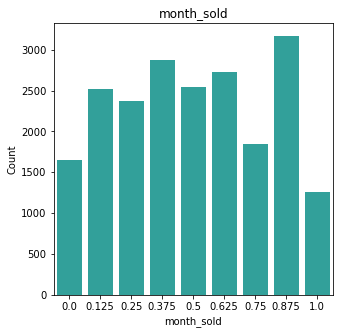

   month_sold  Count  Percent
0       0.875   3167    15.11
1       0.375   2869    13.69
2       0.625   2727    13.01
3       0.500   2549    12.16
4       0.125   2517    12.01
5       0.250   2369    11.30
6       0.750   1851     8.83
7       0.000   1656     7.90
8       1.000   1258     6.00
_________________________________________________________________


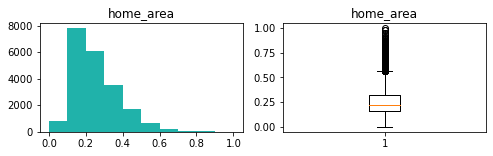

count    20963.000000
mean         0.252772
std          0.124413
min          0.000000
25%          0.159164
50%          0.224678
75%          0.322347
max          1.000000
Name: home_area, dtype: float64


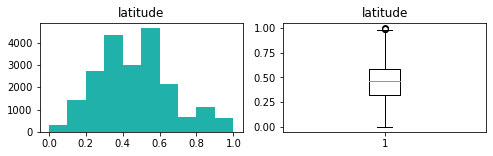

count    20963.000000
mean         0.462894
std          0.196293
min          0.000000
25%          0.317974
50%          0.461414
75%          0.584679
max          1.000000
Name: latitude, dtype: float64


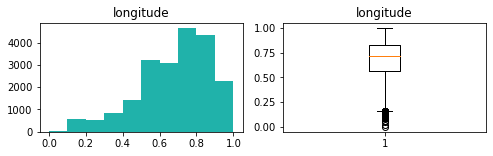

count    20963.000000
mean         0.679766
std          0.197075
min          0.000000
25%          0.562387
50%          0.716586
75%          0.827903
max          1.000000
Name: longitude, dtype: float64


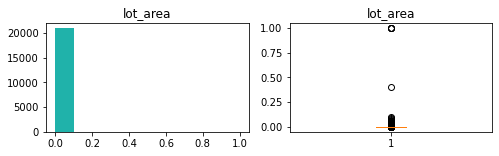

count    20963.000000
mean         0.001514
std          0.014280
min          0.000000
25%          0.000792
50%          0.000970
75%          0.001223
max          1.000000
Name: lot_area, dtype: float64


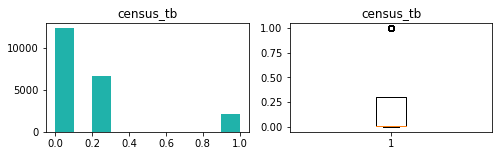

count    20963.000000
mean         0.194955
std          0.297386
min          0.000000
25%          0.004094
50%          0.010820
75%          0.297147
max          1.000000
Name: census_tb, dtype: float64


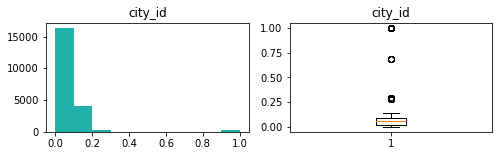

count    20963.000000
mean         0.073451
std          0.114815
min          0.000000
25%          0.022785
50%          0.054294
75%          0.093460
max          1.000000
Name: city_id, dtype: float64


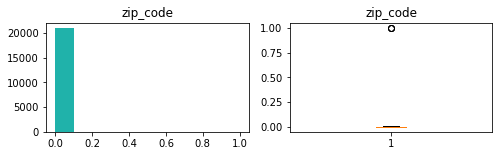

count    20963.000000
mean         0.002287
std          0.012017
min          0.000000
25%          0.000873
50%          0.001669
75%          0.003421
max          1.000000
Name: zip_code, dtype: float64


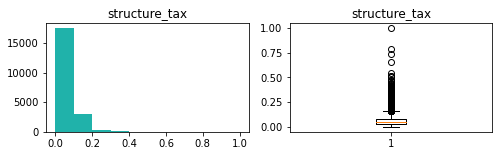

count    20963.000000
mean         0.065534
std          0.047863
min          0.000000
25%          0.033865
50%          0.054206
75%          0.083016
max          1.000000
Name: structure_tax, dtype: float64


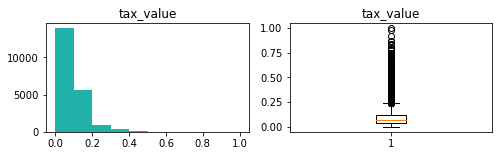

count    20963.000000
mean         0.090054
std          0.079091
min          0.000000
25%          0.037352
50%          0.074374
75%          0.117636
max          1.000000
Name: tax_value, dtype: float64


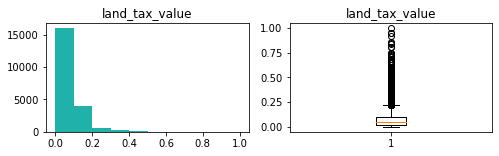

count    20963.000000
mean         0.069687
std          0.074616
min          0.000000
25%          0.016318
50%          0.051619
75%          0.097285
max          1.000000
Name: land_tax_value, dtype: float64


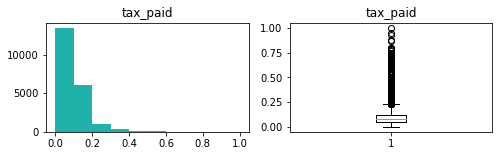

count    20963.000000
mean         0.094924
std          0.075374
min          0.000000
25%          0.046795
50%          0.079891
75%          0.119531
max          1.000000
Name: tax_paid, dtype: float64


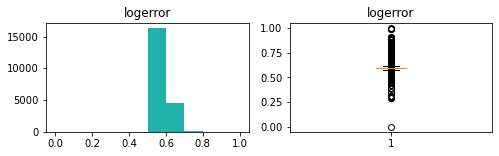

count    20963.000000
mean         0.596601
std          0.021213
min          0.000000
25%          0.591522
50%          0.595281
75%          0.599240
max          1.000000
Name: logerror, dtype: float64


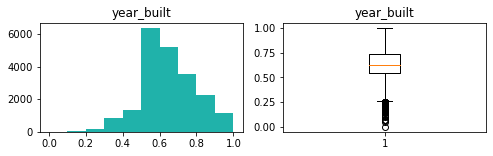

count    20963.000000
mean         0.642784
std          0.149225
min          0.000000
25%          0.548148
50%          0.622222
75%          0.740741
max          1.000000
Name: year_built, dtype: float64


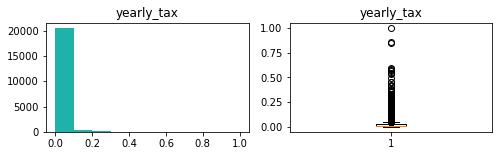

count    20963.000000
mean         0.021635
std          0.031777
min          0.000000
25%          0.006644
50%          0.013426
75%          0.024914
max          1.000000
Name: yearly_tax, dtype: float64


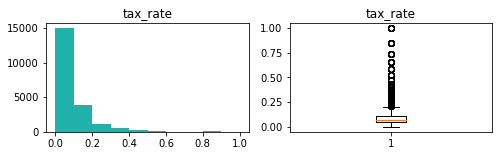

count    20963.000000
mean         0.100149
std          0.099930
min          0.000000
25%          0.049101
50%          0.065496
75%          0.108400
max          1.000000
Name: tax_rate, dtype: float64


In [22]:
# Exploring all variables alone
ex.explore_univariate(scaled_etrain, cats, quants)

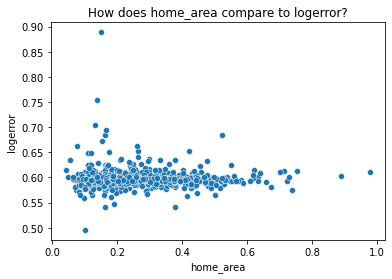

In [23]:
sns.scatterplot(x='home_area', y='logerror',
               data=scaled_etrain.sample(1000))
plt.title("How does home_area compare to logerror?")
plt.show()

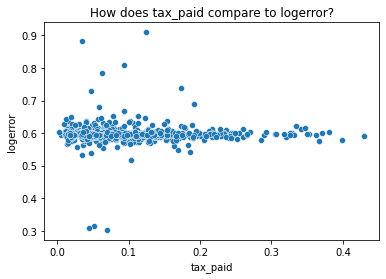

In [24]:
sns.scatterplot(x='tax_paid', y='logerror',
               data=scaled_etrain.sample(1000))
plt.title("How does tax_paid compare to logerror?")
plt.show()

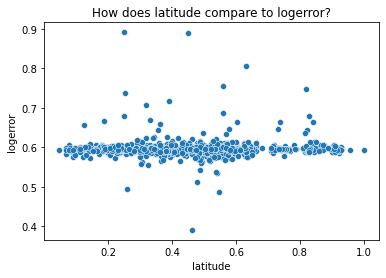

In [25]:
sns.scatterplot(x='latitude', y='logerror',
               data=scaled_etrain.sample(1000))
plt.title("How does latitude compare to logerror?")
plt.show()

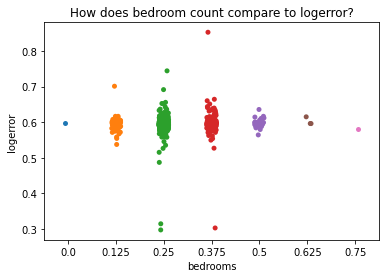

In [26]:
sns.stripplot(x='bedrooms', y='logerror',
               data=scaled_etrain.sample(1000))
plt.title("How does bedroom count compare to logerror?")
plt.show()

#### Scatter takeaways:
- Very little visual correlation in all of the plots
    - outwardly, very little connection to logerror in these variables

### Exploring logerror

In [27]:
# Checking unscaled and scaled means
explore_train.logerror.mean(), scaled_etrain.logerror.mean()

(0.016627345241434527, 0.5966010834512772)

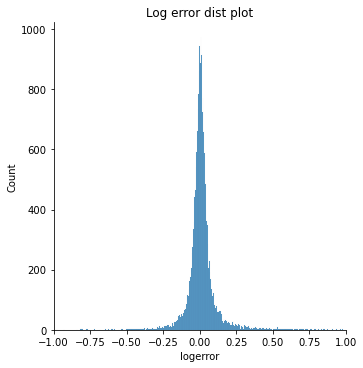

In [28]:
# Basic distplot of target var
sns.displot(explore_train, x="logerror", kind='hist')
plt.title('Log error dist plot')
plt.xlim([-1,1])
plt.ticklabel_format(style='plain')
plt.show()

## Clustering
#### Pre-clustering RFE

In [29]:
# Number of features for RFE models
f = 2

In [30]:
# Selecting the one best feature using RFE
rfe_best = md.rfe_features(enc_train, f, 'logerror')
rfe_best.reset_index(drop = True, inplace= True) # Resetting index

rfe_best

,feat_names,F_rank
0,census_tb,1
1,county_Ventura,1
2,heating_type_Solar,2
3,heating_type_Central,3
4,heating_type_Floor/Wall,4
5,lot_area,5
6,tax_value,6
7,county_Los Angeles,7
8,county_id,8
9,land_tax_value,9


In [31]:
# Selecting best feature using kbest to cross check with rfe
k_best = md.kbest_features(enc_train, f, 'logerror')
k_best

,feat_names,F_Scores
0,bedrooms,7.665216
1,month_sold_0.0,7.055374


#### KBest feats:
- `bedrooms`, `month_sold_0.0`

In [32]:
rfe_feats = rfe_best.feat_names[:f]
rfe_feats

0         census_tb
1    county_Ventura
Name: feat_names, dtype: object

#### RFE (OLS) feats:
- `census_tb`, `county_Ventura`

## Visualizing RFE clusters

In [33]:
# Creating 'cluster_r' cols in explore dfs
X = enc_train[rfe_best.feat_names[:f]]
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)

explore_train['cluster_r'] = kmeans.predict(X)
scaled_etrain['cluster_r'] = kmeans.predict(X)
enc_train['cluster_r'] = kmeans.predict(X)



explore_train.cluster_r.value_counts()

0    18894
1     2069
Name: cluster_r, dtype: int64

In [34]:
kmeans.cluster_centers_

array([[0.10680371, 0.        ],
       [0.99994888, 1.        ]])

In [35]:
rfe_best.feat_names[:f]

0         census_tb
1    county_Ventura
Name: feat_names, dtype: object

In [36]:
# Calculating centroids
centroids = pd.DataFrame(kmeans.cluster_centers_, columns = [rfe_best.feat_names[:f]])
centroids

feat_names,census_tb,county_Ventura
0,0.106804,9.575674e-15
1,0.999949,1.000000e+00


Text(0.5, 1.0, 'Visualizing cluster_r Centers')

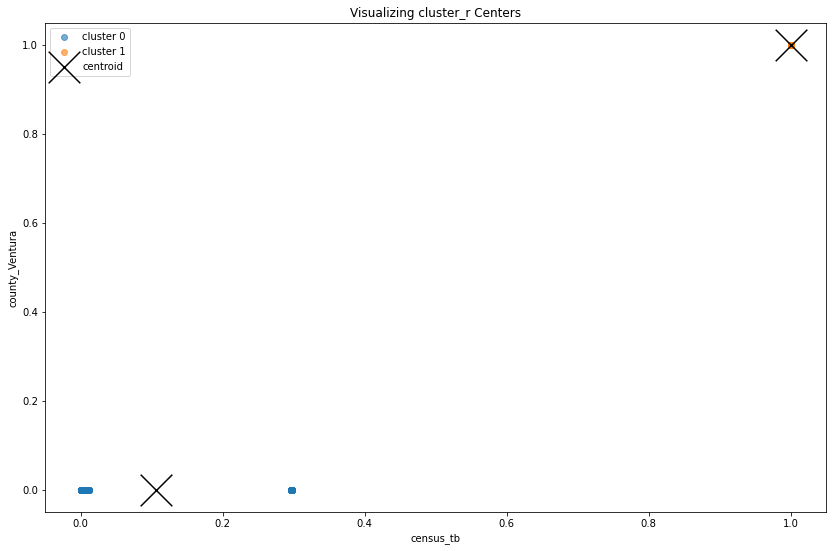

In [37]:
plt.figure(figsize=(14, 9))

for cluster, subset in enc_train.groupby('cluster_r'):
    plt.scatter(subset[rfe_best.feat_names[0]], subset[rfe_best.feat_names[1]], label='cluster ' + str(cluster), alpha=.6)

centroids.plot.scatter(x=rfe_best.feat_names[0], y=rfe_best.feat_names[1], c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel(rfe_best.feat_names[0])
plt.ylabel(rfe_best.feat_names[1])
plt.title('Visualizing cluster_r Centers')

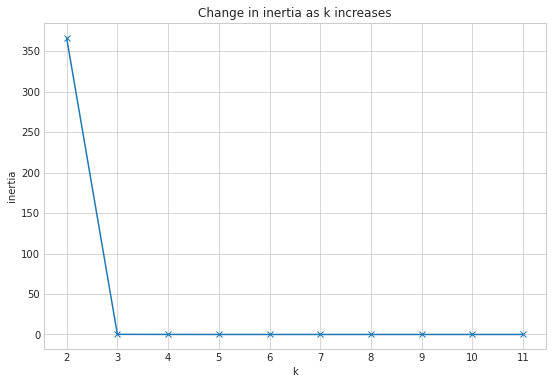

In [38]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

#### RFE takeaways:
- No clusters are especially useful or indicated

## Visualizing KBest clusters

In [39]:
# Creating 'cluster1' cols in explore dfs
X = enc_train[k_best.feat_names]
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)

explore_train['cluster_k'] = kmeans.predict(X)
scaled_etrain['cluster_k'] = kmeans.predict(X)
enc_train['cluster_k'] = kmeans.predict(X)



explore_train.cluster_k.value_counts()

2    9671
0    7795
1    1851
3    1646
Name: cluster_k, dtype: int64

In [40]:
# Calculating centroids
centroids = pd.DataFrame(kmeans.cluster_centers_, columns = [k_best.feat_names])
centroids

feat_names,bedrooms,month_sold_0.0
0,0.396071,2.858824e-15
1,0.299163,1.000000e+00
2,0.250000,4.912737e-15
3,0.122722,-6.106227e-16


Text(0.5, 1.0, 'Visualizing cluster_r Centers')

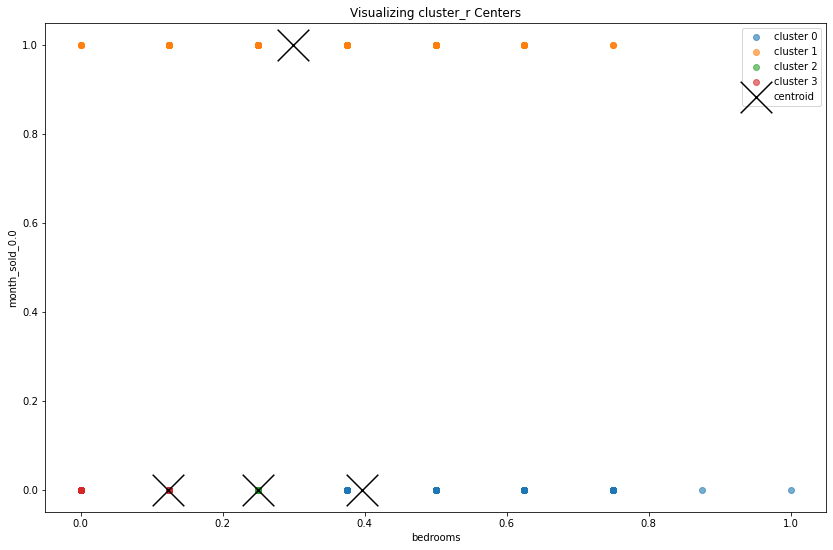

In [41]:
# Visualizing clusters and centroids
plt.figure(figsize=(14, 9))

for cluster, subset in enc_train.groupby('cluster_k'):
    plt.scatter(subset[k_best.feat_names[0]], subset[k_best.feat_names[1]], label='cluster ' + str(cluster), alpha=.6)

centroids.plot.scatter(x=k_best.feat_names[0], y=k_best.feat_names[1], c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel(k_best.feat_names[0])
plt.ylabel(k_best.feat_names[1])
plt.title('Visualizing cluster_r Centers')

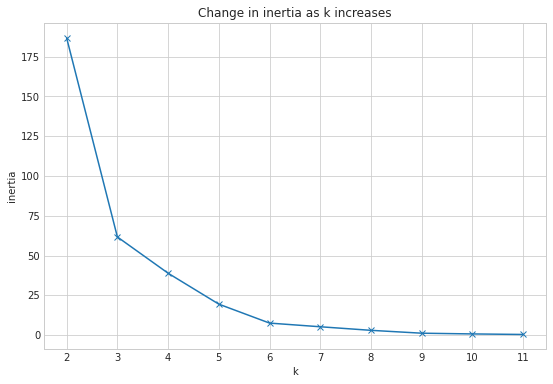

In [42]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

#### K_best takeaways:
- Elbow at 4
- Better choices than RFE

In [43]:
# Adding clusters to categorical vars
cats.append('cluster_k')
cats.append('cluster_r')

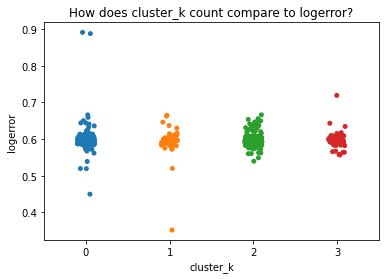

In [44]:
sns.stripplot(x='cluster_k', y='logerror',
               data=scaled_etrain.sample(1000))
plt.title("How does cluster_k count compare to logerror?")
plt.show()

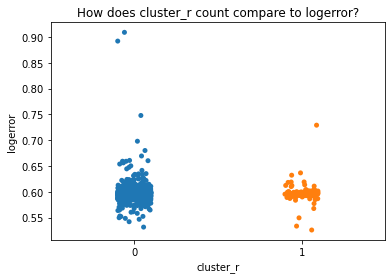

In [45]:
sns.stripplot(x='cluster_r', y='logerror',
               data=scaled_etrain.sample(1000))
plt.title("How does cluster_r count compare to logerror?")
plt.show()

### Clustering Stat-Tests:
- $Q_1$: Does cluster_k have a different logerror mean than the overall logerror mean?
- $Q_2$: Does cluster_r have a different logerror mean than the overall logerror mean?

#### Q1: Does cluster_k have a different logerror mean than the average logerror mean?
- $H_0$: cluster_k has the same logerror mean compared to the overall logerror mean.
- $H_a$: cluster_k has different logerror mean compared to the overall logerror mean.

In [46]:
cluster_k_log = enc_train[['cluster_k', 'logerror']].logerror
μ = enc_train.logerror

In [47]:
stats.mannwhitneyu(cluster_k_log, μ)

MannwhitneyuResult(statistic=219723684.5, pvalue=0.49999983902057754)

#### Q1: Does cluster_r have a different logerror mean than the average logerror mean?
- $H_0$: cluster_r has the same logerror mean compared to the average logerror mean.
- $H_a$: cluster_r has different logerror mean compared to the average logerror mean.

In [48]:
cluster_r_log = enc_train[['cluster_r', 'logerror']].logerror
μ = enc_train.logerror

In [49]:
stats.mannwhitneyu(cluster_r_log, μ)

MannwhitneyuResult(statistic=219723684.5, pvalue=0.49999983902057754)

### Clustering Takeaways:
- Neither cluster particularly indicative of logerror
- Accept $H_0$ for both questions regarding mean comparisons vs logerror
    - Both clusters are not correlated with logerror

# Modeling
- X/y split
- Encoding variables for modeling
- Find model of best fit
- Evaluate model with metrics function
- Run model on test data and evaluate

In [50]:
# X/y split with target = logerror
X_train, X_validate, X_test, y_train, y_validate, y_test = wr.train_validate_test_split(zillow_prep, target = 'logerror')

In [51]:
# Encoding cols for modeling
cols =['heating_type', 'county', 'month_sold']

X_train, X_validate, X_test = ex.encode_cols(X_train, X_validate, X_test, cols)

### Best Model: LinearRegression (OLS)

In [52]:
# Cols based off kbest, rfe and statistical tests
cols_to_model = ['census_tb', 'county_Ventura', 'bedrooms',
                 'month_sold_1', 'home_area', 'latitude', 'longitude', 'tax_paid']


In [53]:
# Creating OLS dfs and evaluation metrics df
ols_train, ols_validate, ols_test, ols_error, ols_sig = md.lin_reg(X_train, X_validate, X_test, y_train, y_validate, y_test, cols_to_model, 'logerror', 
                                                                   model_type=LinearRegression(normalize=True))

In [54]:
# Df of model error metrics
ols_error

,metric,model_error,error_delta
0,SSE_train,577.155739,-1.294461
1,MSE_train,0.027532,-0.000062
2,RMSE_train,0.165928,-0.000186
3,SSE_validate,239.126763,-339.323436
4,MSE_validate,0.026614,-0.000980
5,RMSE_validate,0.163138,-0.002976
6,SSE_test,148.396612,-430.053588
7,MSE_test,0.019821,-0.007773
8,RMSE_test,0.140786,-0.025328
0,SSE_baseline,578.450200,NaN


In [55]:
# Df for model significance metrics
ols_sig

,metric,model_significance
0,ESS_train,1.294461
1,R2_train,0.002238
2,TSS,578.450200
3,ESS_validate,0.617669
4,R2_validate,0.002579
5,ESS_test,0.501071
6,R2_test,0.003366
0,ESS_baseline,0.000000
1,TSS_baseline,578.450200
2,R^2_baseline,0.000000


In [56]:
# Evaluation of best preforming (OLS) model
rmse_baseline = ols_error[ols_error.metric == 'RMSE_baseline'].model_error.values[0]
rmse_train_ols = ols_error[ols_error.metric == 'RMSE_train'].model_error.values
rmse_validate_ols = ols_error[ols_error.metric == 'RMSE_validate'].model_error.values
rmse_test_ols = ols_error[ols_error.metric == 'RMSE_test'].model_error.values
r_2_train = ols_sig[ols_sig.metric == 'R2_train'].model_significance.values
r_2_validate = ols_sig[ols_sig.metric == 'R2_validate'].model_significance.values
r_2_test = ols_sig[ols_sig.metric == 'R2_test'].model_significance.values

print("Baseline RMSE: ", rmse_baseline,
     "\n-------------------\nRMSE using OLS:\nTrain/In-Sample: ", rmse_train_ols, 
     "\nValidate/Out-of-Sample: ", rmse_validate_ols,
      "\nTest/Out-of-Sample: ", rmse_test_ols, 
     "\nR^2 Train: ", r_2_train, 
     "\nR^2 Validate: ", r_2_validate, 
     "\nR^2 Test: ", r_2_test)

Baseline RMSE:  0.16611401316289964 
-------------------
RMSE using OLS:
Train/In-Sample:  [0.16592804] 
Validate/Out-of-Sample:  [0.16313797] 
Test/Out-of-Sample:  [0.14078555] 
R^2 Train:  [0.00223781] 
R^2 Validate:  [0.00257875] 
R^2 Test:  [0.00336596]


In [57]:
md.better_than_baseline(ols_test.logerror_test, ols_test.yhat_test, ols_sig[ols_sig.metric == 'R2_test'].model_significance.values, ols_sig[ols_sig.metric == 'R^2_baseline'].model_significance.values)

'RMSE better than baseline\nR^2 better than baseline'

## Error Visualization:

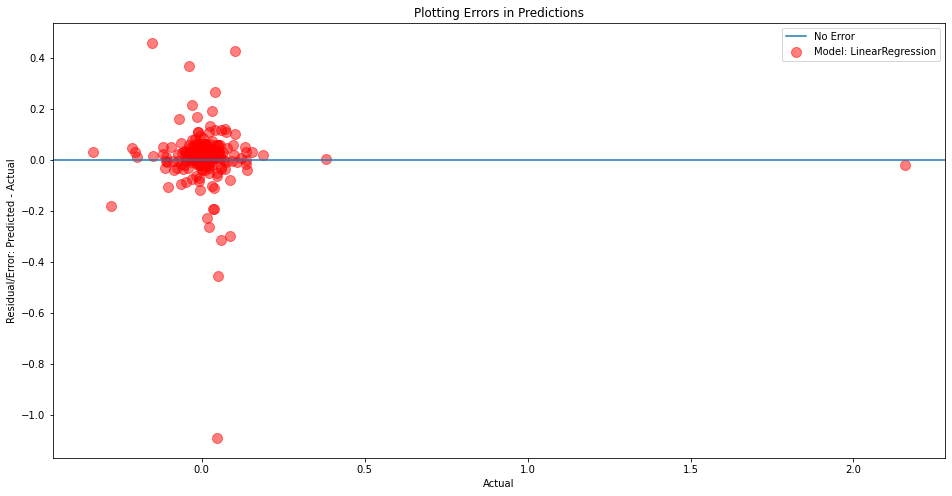

In [58]:
md.plot_errors(y_test, ols_test.yhat_baseline, ols_test.yhat_test)

### Error Plot:
- Clustered around 0 has more error than the values on either end of X-axis

## Modeling Takeaways:
- RMSE of my OLS preformed better than baseline by ~.02 points
- R^2 score indicates very miniscule model significance
- Overall, model *better* than baseline but only by a couple hundredths of points and with almost no significance.
- OLS model seems to be underfit

# Key Takeaways:
> - Despite beating the baseline RMSE by a few hundredths, the overall significance means the model explains very little of the error. Overall, the models preformance is lackluster and mostly insignificant. 
> - None of the clusters I created were especially useful and usually ranked last in feature rank on RFE rankings.
> - Difficult to find a meaningful driver of logerror with clusters or engineered features.

# Conclusion:
> #### My reccomendation 
> - I reccomend to stick with existing zestimate algorithm and not rely on the features presented here to predict the logerror of the zestimate as almost all of the models I made failed to beat baseline RMSE and even the one that did failed to present meaningful significance. 

> #### If given more time
> - I would like to try more combinations of features, perhaps some that I dropped were indicative of logerror. Additionally, I would like to take more time to create features from the existing features and use those in clustering. Overall, I would like to tune my model in order to see an increase in the preformance of my model in both RMSE compared to baseline and R^2 significance.